In [2]:
#!pip install nltk
import json
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from nltk.tokenize import sent_tokenize, word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\caste\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\caste\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
#1.1
# Function to clean and normalize text fields
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\x00-\x7F]+', '', text) # Delete no ASCII character
    text = re.sub(r'[^\w\s]', '', text) # Remove punctuation
    text = re.sub(r'\s+', ' ', text) # Replace multiple spaces
    tokens = text.split() # Tokenize
    tokens = [word for word in tokens if word not in stop_words]
    stemmed = [stemmer.stem(word) for word in tokens] # Apply stemming

    return ' '.join(stemmed)


In [4]:
#1.2
with open('fashion_products_dataset.json', 'r', encoding='utf-8') as f:
    corpus = json.load(f)
# Text cleaning to title and description fields
for doc in corpus:
    doc['title_clean'] = clean_text(doc.get('title', ''))
    doc['description_clean'] = clean_text(doc.get('description', ''))

REQUIRED_FIELDS = [
    'pid', 'title', 'description', 'brand', 'category', 'sub_category',
    'product_details', 'seller', 'out_of_stock', 'selling_price',
    'discount', 'actual_price', 'average_rating', 'url'
]
# We ensure all required fields are present in each document
def ensure_fields(doc):
    for field in REQUIRED_FIELDS:
        if field not in doc:
            doc[field] = None
    return doc

# We apply field completion to the entire corpus
corpus = [ensure_fields(doc) for doc in corpus]



In [5]:
# 1.3 Creation of a new variable that aggrups multiple features
def build_metadata_text(doc):
    brand = doc.get('brand', '')
    category = doc.get('category', '')
    sub_category = doc.get('sub_category', '')
    seller = doc.get('seller', '')
    product_details = ' '.join(
        f"{k} {v}" for d in doc.get('product_details', []) for k, v in d.items()
    )
    return f"{brand} {category} {sub_category} {product_details} {seller}".lower()

for doc in corpus:
    doc['metadata_text'] = build_metadata_text(doc)

In [6]:
#1.4
def normalize_numeric_fields(doc):
    # Convert price and rating fields to numeric types
    try:
        doc['selling_price'] = float(doc['selling_price'].replace(',', ''))
    except:
        doc['selling_price'] = None
    try:
        doc['actual_price'] = float(doc['actual_price'].replace(',', ''))
    except:
        doc['actual_price'] = None
    try:
        doc['discount'] = int(doc['discount'].replace('% off', '').strip())
    except:
        doc['discount'] = None
    try:
        doc['average_rating'] = float(doc['average_rating'])
    except:
        doc['average_rating'] = None
    return doc

# We apply normalization to the entire corpus
corpus = [normalize_numeric_fields(doc) for doc in corpus]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28080 entries, 0 to 28079
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   _id                28080 non-null  object 
 1   actual_price       27303 non-null  float64
 2   average_rating     25819 non-null  float64
 3   brand              28080 non-null  object 
 4   category           28080 non-null  object 
 5   crawled_at         28080 non-null  int64  
 6   description        28080 non-null  object 
 7   discount           27225 non-null  float64
 8   images             28080 non-null  object 
 9   out_of_stock       28080 non-null  bool   
 10  pid                28080 non-null  object 
 11  product_details    28080 non-null  object 
 12  seller             28080 non-null  object 
 13  selling_price      28078 non-null  float64
 14  sub_category       28080 non-null  object 
 15  title              28080 non-null  object 
 16  url                280

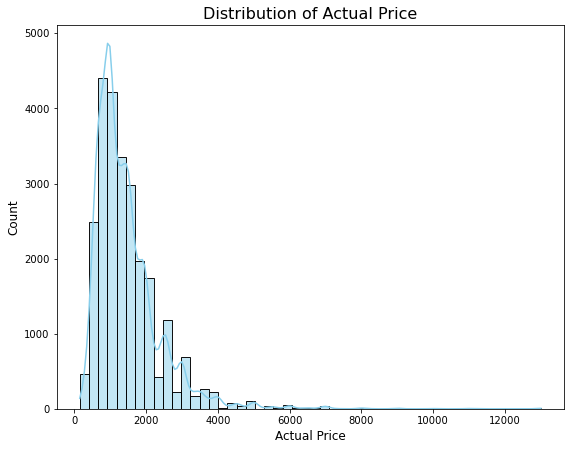

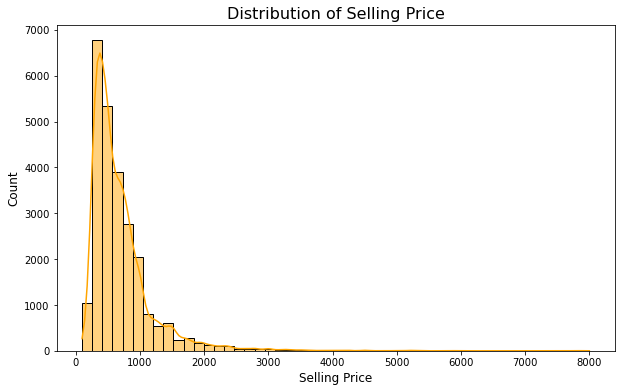

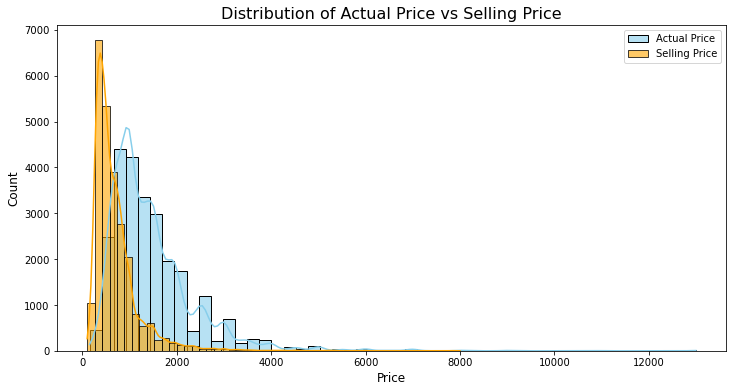

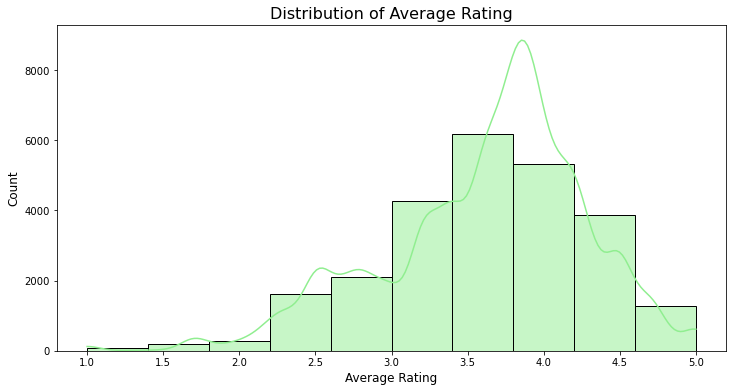

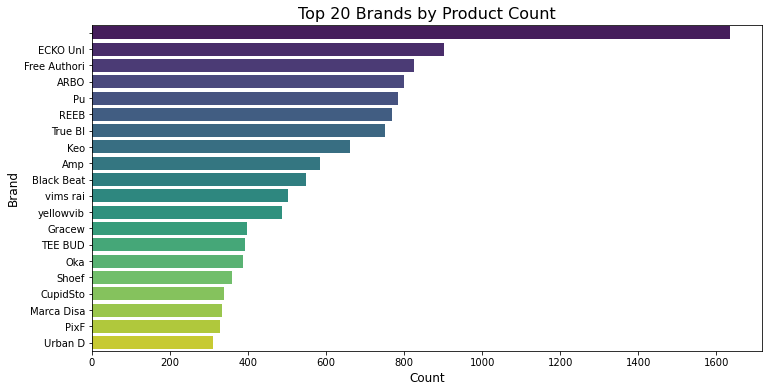

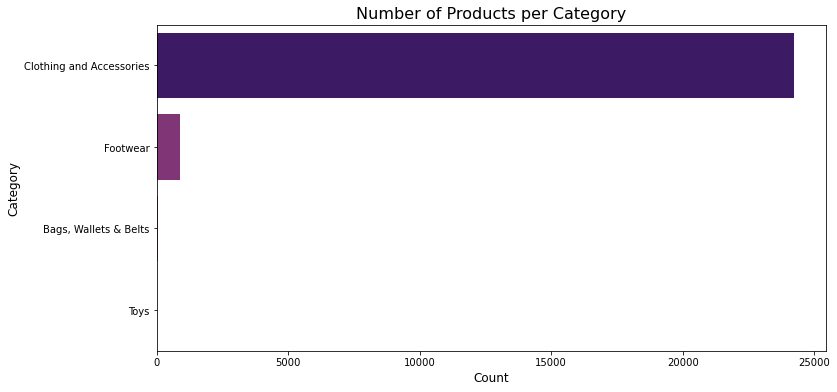

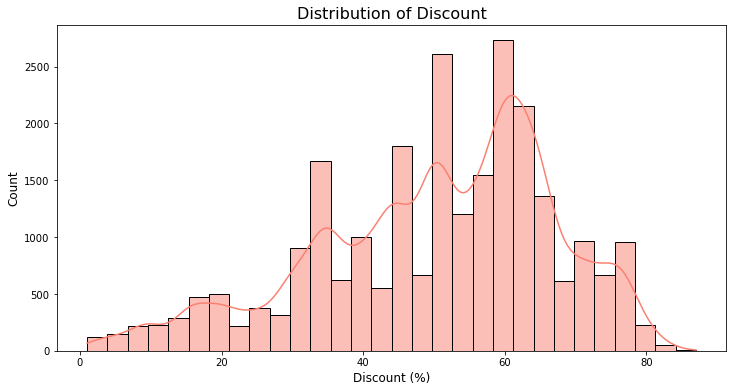

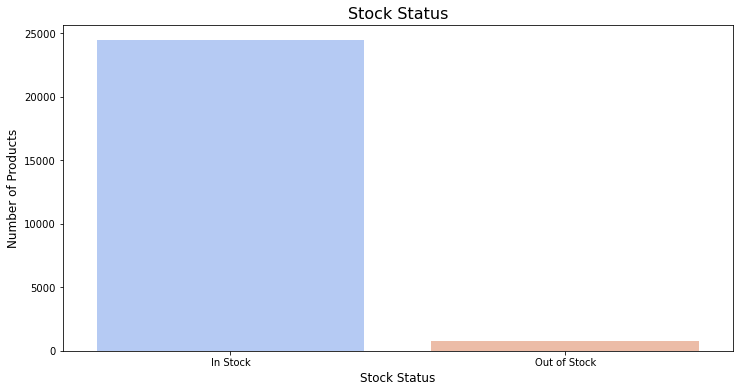

In [7]:
df = pd.DataFrame(corpus)
df.info()
missing_values_per_column = df.isnull().sum()
print(missing_values_per_column)
# Drop rows with empty slots for easier analysis
df = df.dropna()

# Preview of the data
df.info()
df.head()
mean_values = df[['selling_price', 'actual_price', 'discount']].mean()
print(mean_values)
max_values = df[['selling_price', 'actual_price', 'discount']].max()
print(max_values)
# Increase overall figure size
plt.figure(figsize=(20, 24))  # <- Bigger figure

# 1. Actual Price Distribution
plt.subplot(3, 2, 1)
sns.histplot(df['actual_price'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of Actual Price', fontsize=16)
plt.xlabel('Actual Price', fontsize=12)
plt.ylabel('Count', fontsize=12)

# 2. Distribution of selling_price
plt.figure(figsize=(10,6))
sns.histplot(df['selling_price'], bins=50, kde=True, color='orange')
plt.title('Distribution of Selling Price', fontsize=16)
plt.xlabel('Selling Price', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

# 3. Combined distribution of actual_price and selling_price
plt.figure(figsize=(12,6))
sns.histplot(df['actual_price'], bins=50, kde=True, color='skyblue', label='Actual Price', alpha=0.6)
sns.histplot(df['selling_price'], bins=50, kde=True, color='orange', label='Selling Price', alpha=0.6)
plt.title('Distribution of Actual Price vs Selling Price', fontsize=16)
plt.xlabel('Price', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend()
plt.show()

# 4. Average Rating Distribution
plt.figure(figsize=(12,6))
sns.histplot(df['average_rating'], bins=10, kde=True, color='lightgreen')
plt.title('Distribution of Average Rating', fontsize=16)
plt.xlabel('Average Rating', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

# 5. Count of Different Brands (Top 20)
plt.figure(figsize=(12,6))
top_brands = df['brand'].value_counts().head(20)
sns.barplot(x=top_brands.values, y=top_brands.index, palette='viridis')
plt.title('Top 20 Brands by Product Count', fontsize=16)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Brand', fontsize=12)
plt.show()

# 6. Count per Category
plt.figure(figsize=(12,6))
category_counts = df['category'].value_counts()
sns.barplot(x=category_counts.values, y=category_counts.index, palette='magma')
plt.title('Number of Products per Category', fontsize=16)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Category', fontsize=12)
plt.show()

# 7. Discount Distribution
plt.figure(figsize=(12,6))
sns.histplot(df['discount'], bins=30, kde=True, color='salmon')
plt.title('Distribution of Discount', fontsize=16)
plt.xlabel('Discount (%)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

# 8. Out of Stock vs In Stock
plt.figure(figsize=(12,6))
stock_counts = df['out_of_stock'].value_counts()
sns.barplot(x=stock_counts.index.map({True: 'Out of Stock', False: 'In Stock'}), y=stock_counts.values, palette='coolwarm')
plt.title('Stock Status', fontsize=16)
plt.xlabel('Stock Status', fontsize=12)
plt.ylabel('Number of Products', fontsize=12)
plt.show()

Total words: 459761
Vocabulary size: 5680
Most common words: [('tshirt', 11177), ('cotton', 8935), ('comfort', 7399), ('wear', 7375), ('shirt', 6974), ('look', 5707), ('made', 5010), ('fit', 5008), ('casual', 4801), ('fabric', 4411), ('print', 4147), ('women', 4004), ('sleev', 3746), ('design', 3685), ('qualiti', 3661), ('men', 3463), ('day', 3158), ('style', 2847), ('100', 2786), ('make', 2743)]


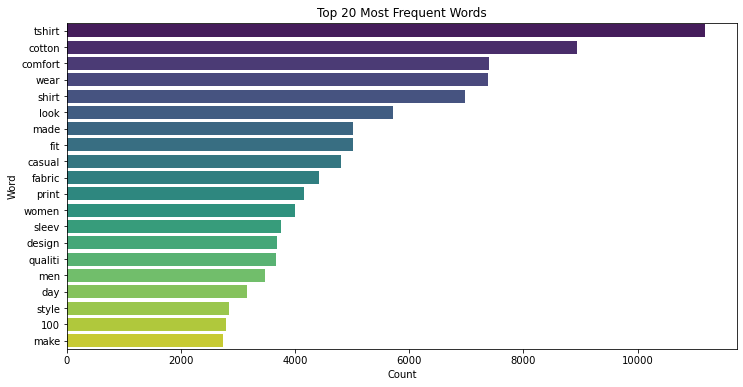

Average sentence length: 17.92245151879183


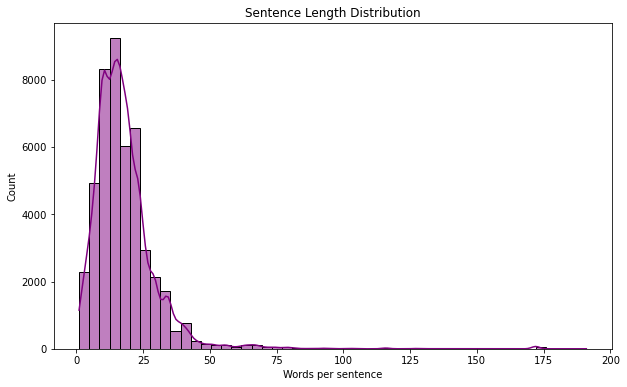


 Top 10 products by rating:
                                                   title  average_rating
2965              Solid Men Polo Neck Multicolor T-Shirt             5.0
18788             Printed Women Round Neck Black T-Shirt             5.0
25015           Full Sleeve Color Block Women Sweatshirt             5.0
4376   Solid Women Polo Neck Multicolor T-Shirt  (Pac...             5.0
14286                         Tapered Fit Men Blue Jeans             5.0
25712               Printed Men Round Neck Black T-Shirt             5.0
4399   Solid Men Polo Neck Multicolor T-Shirt  (Pack ...             5.0
18675                 Solid Women Round Neck Red T-Shirt             5.0
7620   Solid Men Round Neck Multicolor T-Shirt  (Pack...             5.0
7611                    Solid Men Round Neck Red T-Shirt             5.0

 Top 10 most expensive products:
                                             title  actual_price
10315                       2 Piece Solid Men Suit       12999.0
2608

In [8]:
df = pd.DataFrame(corpus)
df = df.dropna()  # remove rows with missing values

# 2. Word counting and vocabulary 
all_text = ' '.join(df['description_clean'])
words = all_text.split()
total_words = len(words)
vocab = set(words)
vocab_size = len(vocab)
word_counts = Counter(words)
most_common_words = word_counts.most_common(20)

print("Total words:", total_words)
print("Vocabulary size:", vocab_size)
print("Most common words:", most_common_words)
 
# top 20 most frequent words
plt.figure(figsize=(12,6))
top_words, top_counts = zip(*most_common_words)
sns.barplot(x=list(top_counts), y=list(top_words), palette='viridis')
plt.title('Top 20 Most Frequent Words')
plt.xlabel('Count')
plt.ylabel('Word')
plt.show()

# 3. Sentence length distribution 
sentence_lengths = []
for desc in df['description']:
    for s in sent_tokenize(desc):
        sentence_lengths.append(len(word_tokenize(s)))

print("Average sentence length:", np.mean(sentence_lengths))

plt.figure(figsize=(10,6))
sns.histplot(sentence_lengths, bins=50, kde=True, color='purple')
plt.title('Sentence Length Distribution')
plt.xlabel('Words per sentence')
plt.ylabel('Count')
plt.show()

# 4. Rankings 
print("\n Top 10 products by rating:")
print(df.sort_values(by='average_rating', ascending=False).head(10)[['title','average_rating']])

print("\n Top 10 most expensive products:")
print(df.sort_values(by='actual_price', ascending=False).head(10)[['title','actual_price']])

print("\n Top 10 products with highest discount:")
print(df.sort_values(by='discount', ascending=False).head(10)[['title','discount']])

print("\n Top 10 brands:")
print(df['brand'].value_counts().head(10))

print("\nTop 10 sellers:")
print(df['seller'].value_counts().head(10))